In [19]:
from ctypes import CDLL
randlib = CDLL("libc.so.6")
import time, sys
import multiprocessing as mp

# Look here for spoilers of what I used to speed up code
import numpy as np
from numba import jit 
from numba.experimental import jitclass
from numba import float32, int32
from numba import types



def genrand3dpt(MIN, MAX):
    X = (MAX-MIN)*(float(randlib.rand())/2147483647)+MIN
    Y = (MAX-MIN)*(float(randlib.rand())/2147483647)+MIN
    Z = (MAX-MIN)*(float(randlib.rand())/2147483647)+MIN
    return X,Y,Z

class point:
    def __init__(self, x:float ,y: float, z: float):
        self.x, self.y, self.z = x, y, z
    
def setCase(case):
    if(case=='T1'):
        seed = 7
        pts = 40000
        cores = 1
        expected = "Expected Min, Max: 8.705  16830.027\n"
    elif case=='T2':
        seed = 7
        pts = 40000
        cores =2
        expected = "Expected Min, Max: 8.705  16830.027\n"
    elif case=='T3':
        seed = 7
        pts = 80000
        cores = 1
        expected = "Expected Min, Max: 0.260  16989.490\n"
    elif case=='T4':
        seed = 7
        pts = 80000
        cores = 2
        expected = "Expected Min, Max: 0.260  16989.490\n"
    elif case=='T5':
        seed = 7
        pts = 80000
        cores = 4
        expected = "Expected Min, Max: 0.260  16989.490\n"
    elif case=='T6':
        seed = 111
        pts = 111000
        cores = 3
        expected = "Expected Min, Max: 1.555  16965.943\n"
    return seed, pts, cores, expected

# Parallelization, Calling C and Other Methods: Part 2 of the Hit Series "Speeding Up My Code"

I had never done parallel coding in Python before this project, but I had done it in C in Dr. Butler's class. I needed to do some reading on how to spawn processes. Luckily, most of my work was easy because it was easily translated. Below is my initial implementation. I started with Numba because it was already blindingly fast.

I would be remiss if I did not mention the fact that Python doesn't benefit from threading inherently because of something called the GIL: Global Interpreter Lock. Here is a good article that goes into detail about how it affects the whole system: https://realpython.com/python-gil/#what-problem-did-the-gil-solve-for-python

TL;DR: The GIL completely neuters threading, therefore it is easier to operate with processes instead.

### How does a process differ from a thread?
To put it simply, a process is a spawned python instance. It will contain copies of variables in scope, arrays, values etc and runs independently of other processes apart from its parent, and they cannot really interact with one another. They do not share memory with each other. Threads share memory and can also affect other threads. In terms of hierarchy, processes can contain multiple threads, but threads cannot contain processes.

By using multiprocessing instead of threading, we are essentially bypassing the GIL because we do not have to wait for blocking segments of one python process. Instead we copy our data into more processes and send them on their way doing calculations. This allows us to actually benefit from Parallelization.

A little more reading if you are interested:
https://stackoverflow.com/questions/3044580/multiprocessing-vs-threading-python

### Table of Cases
Not so much concerned with timing this time around compared to the C because the threading process is different. Moreso concerned with using out speed up techniques in tandem with parallel programming.

| Case Name |Points| Threads |
|:---:       |:---:|   :----:   | 
| T1 | 40000 | 1 |
| | | |
|T2|40000|2|
| | | |
|T3|80000|2|
| | | |
|T4|80000|2 | 
| | | |
|T5|80000|4|
| | | |
|T6|111000|7|

You can get a general idea of how many calculations need to be performed by a given case using this formula:
$\frac{n(n-1)}{2}$ where n = number of points - 1.

For funsies, case 6 requires this many calculations: 110999(111000) / 2 = 6,160,444,500

That is so large that jupyter notebook thinks it's a phone number. Compare this to our largest case on single core:

39999(40000)/2 = 799,980,000

In my current configuration, I balance the cores via this method in the picture below:

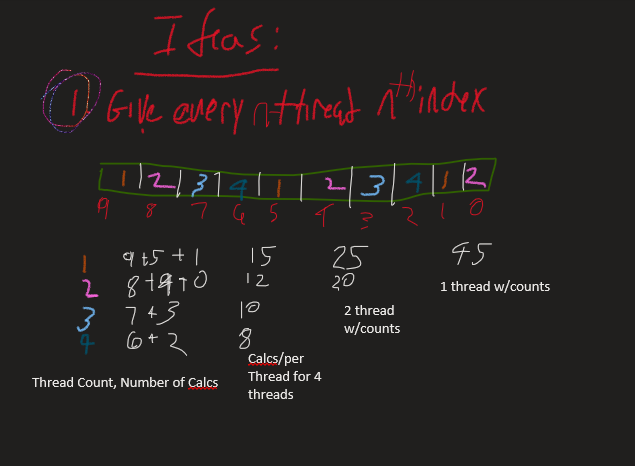

Basically I give each thread the whole array (a pointer to it in C) and then tell it to start at its thread number (starting with zero). After it performs one pass, instead of incrementing the left hand comparison value by one, it increments it by the total thread count. This must have been the optimal way to balance it because it comes out to about equal each time and I got an A on the original assignment

A few extra notes on the picture: the red numbers below the array are the number of calculations that are performed if that is the starting index and the numbers inside the array represent the threads by number (not starting with zero for clarity). These are my original notes from when I coded the project in Butler's class.

In [40]:
spec = [
    ('array', float32[:,:]),
    ('value', float32),
    ('value', float32),
    ('value', int32),
    ('value', int32),    
]


class args:
    def __init__(self, points, strt, cnt):
        self.pts=points
        self.MAX = 0
        self.MIN = 1.7976931348623157e+308
        self.start = strt
        self.ptcnt = cnt
        
@jit(types.Tuple((float32, float32))(float32[:,:],float32,float32,int32,int32))
def shortest_numba(pts, max, min, start, ptcnt):
    for i in range(start, ptcnt,corecnt):
        for j in range(i+1, ptcnt):
            distance = (pts[i][0] - pts[j][0])**2 + (pts[i][1] - pts[j][1])**2 + (pts[i][2]- pts[j][2])**2
            if max < distance:
                max = distance
            elif min  > distance:
                min  = distance
    min, max = min **0.5, max**0.5
    return max, min

def numbaworker(q, passer):
    q.put(shortest_numba(np.float32(passer.pts), np.float32(passer.MAX), np.float32(passer.MIN), np.int32(passer.start), np.int32(passer.ptcnt)))   

def parallel():
    seed, pts, corecnt, expected = setCase('T6')
    randlib.srand(seed)
    print(expected)

    Q = mp.Queue()

    points = np.empty((pts,3), dtype=np.double)
    for i in range(pts):
        points[i]  = genrand3dpt(0, 10000) # call random points macro   
    MAXandMINS=[]
    procs=list()
    
    t1= time.time()    # to maintain consistency, I am timing like butler does.     
    for i in range(corecnt):
        passer = args(points=points, strt=i, cnt=len(points))
        proc = mp.Process(target=numbaworker, args=(Q, passer))
        proc.start()
        procs.append(proc)

    for i, proc in enumerate(procs):
        proc.join()
    
    for i in range(corecnt):
        mx, mn = Q.get()
        MAXandMINS.append(mx)
        MAXandMINS.append(mn)
    print(min(MAXandMINS),max(MAXandMINS))
    t2=time.time()
    print(t2-t1)
parallel()

Expected Min, Max: 1.555  16965.943

1.5551254749298096 16965.943359375
4.6719701290130615


I noticed something strange. No matter what core count I ran it at, the numba was fast and sometimes even faster with one core. It was running the same speed as the C. My hunch is that under the hood, Numba is actually doing some parallelization on its own. I decided to test this theory by doing a vanilla python solution just to see if I was going crazy.

## Vanilla Python with Parallel

In [3]:
%%time
class args:
    def __init__(self, points, strt, cnt):
        self.pts=points
        self.MAX = 0
        self.MIN = 1.7976931348623157e+308
        self.start = strt
        self.ptcnt = cnt

def shortest(pts, max, min, start, ptcnt,core):
    for i in range(start, ptcnt,core):
        for j in range(i+1, ptcnt):
            distance = (pts[i][0] - pts[j][0])**2 + (pts[i][1] - pts[j][1])**2 + (pts[i][2]- pts[j][2])**2
            if max < distance:
                max = distance
            elif min  > distance:
                min  = distance
    min, max = min **0.5, max**0.5
    return max, min

def worker(q, passer,procs):
    q.put(shortest(passer.pts, passer.MAX, passer.MIN, passer.start, passer.ptcnt,procs))


def parallel():
    seed, pts, cores, expected = setCase('T2')
    randlib.srand(seed)
    print(expected)

    Q = mp.Queue()

    points = np.empty((pts,3), dtype=np.double)
    for i in range(pts):
        points[i]  = genrand3dpt(0, 10000) # call random points macro   
    MAXandMINS=[]
    procs=list()

    t1= time.time()    # to maintain consistency, I am timing like butler does.     
    for i in range(cores):
        passer = args(points=points, strt=i, cnt=len(points))

        proc = mp.Process(target=worker, args=(Q, passer, cores))
        proc.start()
        procs.append(proc)

    for i, proc in enumerate(procs):
        proc.join()
    
    for i in range(cores):
        mx, mn = Q.get()
        MAXandMINS.append(mx)
        MAXandMINS.append(mn)
    print(min(MAXandMINS), max(MAXandMINS))
    
    t2=time.time()
    print("Butler Timing:", t2-t1)

parallel()

Expected Min, Max: 9.730 16509.943

8.704671647258278 16830.026589988684
Butler Timing: 283.47874450683594
CPU times: user 81.4 ms, sys: 21.1 ms, total: 102 ms
Wall time: 4min 43s


This was my initial code for attempting to get my parallel processing working. I could not reach any kind of speed increase whatsoever. Most of the time it ran as slow as the benchmark tests or sometimes even twice as slow. I did some reading about multiprocessing and threading and came to a realization. I wasn't giving it enough cores for it to make a significant difference. once I doubled the threads on the cases, I saw the speed increases I wanted.

It is worth mentioning one thing too:
*Multiprocessing processes don't share memory. They have to make copies of everything.*

I did not run all cases because if I actually ran them with true Python, they would take ages...even with the multithreading.

Enter stage right, Numpy

# Numpy Python with Parallel

In [27]:
%%time
class numpyargs:
    def __init__(self, points, strt, cnt):
        self.pts=points
        self.MAX = 0
        self.MIN = 1.7976931348623157e+308
        self.start = strt
        self.ptcnt = cnt
        
def numpyworker(q, passer,procs):
    q.put(shortest_numpy(passer.pts, passer.MAX, passer.MIN, passer.start, passer.ptcnt,procs))

def numpyparallel():
    seed, pts, cores, expected = setCase('T1')
    randlib.srand(seed)
    print(expected)

    Q = mp.Queue()

    points = np.empty((pts,3), dtype=np.double)
    for i in range(pts):
        points[i]  = genrand3dpt(0, 10000) # call random points macro   
    MAXandMINS=[]
    procs=list()    
        
    t1= time.time()    # to maintain consistency, I am timing like butler does.     
    for i in range(cores):
        passer = numpyargs(points=points, strt=i, cnt=len(points))
        proc = mp.Process(target=numpyworker, args=(Q, passer,cores))
        proc.start()
        procs.append(proc)
        
    for i, proc in enumerate(procs):
        proc.join()
    
    for i in range(cores):
        mx, mn = Q.get()
        MAXandMINS.append(mx)
        MAXandMINS.append(mn)
    print(min(MAXandMINS), max(MAXandMINS))    
    
    t2=time.time()
    print("Butler Timing:", t2-t1)
    
def shortest_numpy(points, loopMAX, loopMIN, start, ptcnt, core):
    
    for i in range(start,ptcnt-1,core):
        shorts =np.subtract(points[i], points[i+1:])**2 # subtracts [i, i+1], [i,i+2]...[i, i+n] where i = index's xyz points
        # Array appearance: [ [(x0-x1)^2, (y0-y1)^2, (z0-z1)^2], [(x0-x2)^2, (y0-y2)^2, (z0-z2)^2], [(x0-xn)^2, y0-yn)^2, (z0-zn)^2]]
        
        shorts=np.add.reduce(shorts, 1) # takes row with xdist, ydist, zdist and adds them all together, turns into column of 
                                        # non square rooted euclidean distance.
            
        # shorts basically equals 1d arr: [((x0-x1)^2 + (y0-y1)^2 + (z0-z1)^2), ((x0-x2)^2+ (y0-y2)^2+ (z0-z2)^2) ]
        if loopMAX < np.amax(shorts):
            loopMAX = np.amax(shorts)
        elif loopMIN > np.amin(shorts):
            loopMIN =  np.amin(shorts)

    return np.sqrt(loopMIN), np.sqrt(loopMAX)

numpyparallel()

Expected Min, Max: 8.705  16830.027

8.704671647258278 16830.026589988684
Butler Timing: 15.566930055618286
CPU times: user 74.5 ms, sys: 0 ns, total: 74.5 ms
Wall time: 15.6 s


I was quite pleased with my numpy results. I recorded their times because I could actually make it through their test cases.

It wasn't hard to get my numpy implementation hooked up with the new multiprocessing stuff, so that was nice.

###  <center>Numpy Python with Parallel</center>

| Case Name | Python Timing  |
| :---: | :---: |
| T1 | **real** 15.6 sec<br/>**user** 74.5 ms<br/>**sys** 0.0 ns <br/>  |
| T2 | **real** 8.21 sec<br/>**user** 68.7 ms<br/>**sys** 9.2 ms<br/>     | 
| T3 | **real** 61 sec<br/>**user** 143 ms <br/>**sys** 0.0 sec<br/>      |  
| T4 | **real** 31.5 sec<br/>**user** 8.91 sec<br/>**sys** 0.0 sec<br/>   |
| T5 | **real** 16.6 sec<br/>**user** 132 ms<br/>**sys** 19.9 ms<br/>     | 
| T6 | **real** 41.6 sec<br/>**user** 199ms<br/>**sys** 0.0 nanosec<br/>  | 

## Final Results
I was very pleased with how easy it was go get multiprocessing working on python. I think the work to get it going wasn't all that hard, and the Process stuff is easy enough to understand syntactically. 

Although the regular python was not fast enough to even run, I am glad to have at least got some results from this effort.